In [ ]:
!pip install tensorflow-datasets

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load COCO 2017 dataset with annotations
dataset, info = tfds.load('coco/2017', with_info=True, data_dir='/notebooks/tensorflow_datasets')

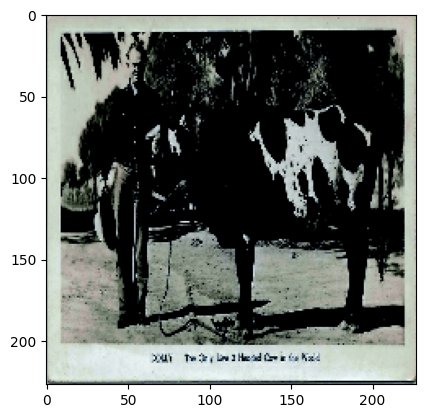

tf.Tensor(
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.], shape=(80,), dtype=float32)


In [63]:
num_classes = 80 # number of classes in COCO dataset

def preprocess(example):
    image = example['image']
    image = tf.image.resize(image, (227, 227))
    image = tf.cast(image, tf.float32) / 256
    mean = [0.485, 0.456, 0.406]
    variance = [0.229, 0.224, 0.225]
    normalization_layer = Normalization(mean=mean, variance=variance)
    image = normalization_layer(image)
    
    objects = example['objects']['label']
    label = tf.reduce_max(tf.one_hot(objects, num_classes), axis=0)
    
    return image, label

batch_size = 32

train_ds = dataset['train'].map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = dataset['validation'].map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
# see a picture and its label
for image, label in train_ds.take(1):
    image_number = 8
    plt.imshow(image[image_number])
    plt.show()
    print(label[image_number])

In [ ]:
input_shape = (227, 227, 3)

model = Sequential()
tf.keras.layers.InputLayer(input_shape=input_shape),
# Convolutional layers
model.add(Conv2D(96, (11, 11), strides=(4, 4), activation="relu", input_shape=(227, 227, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((3, 3), strides=(2, 2)))
model.add(Conv2D(256, (5, 5), activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D((3, 3), strides=(2, 2)))
model.add(Conv2D(384, (3, 3), activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(384, (3, 3), activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D((3, 3), strides=(2, 2)))

# Fully connected layers
model.add(Flatten())
model.add(Dense(4096, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(4096, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="sigmoid"))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model.fit(train_ds, epochs=10, validation_data=val_ds)

model.save('model.h5')
